# Project Code

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from IPython.display import Image
from pydotplus import graph_from_dot_data
from scikitplot.metrics import plot_roc
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, LeaveOneOut, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.externals.six import StringIO

import warnings; warnings.simplefilter('ignore') #TO REMOVE <-keyword for edits        ignore or once

## Read Data

In [2]:
# Train
train_data_labels = pd.read_csv('Dataset/Train/train_labels.csv')
train_data_SBM = pd.read_csv('Dataset/Train/train_SBM.csv')
train_data_FNC = pd.read_csv('Dataset/Train/train_FNC.csv')
train_data_mrg = pd.merge(train_data_labels, train_data_SBM, 'outer', on = 'Id')
train_data = pd.merge(train_data_mrg, train_data_FNC, 'outer', on = 'Id')
## Remove id
train_data = train_data.iloc[:,1:]

# Test
test_data_SBM = pd.read_csv('Dataset/Test/test_SBM.csv')
test_data_FNC = pd.read_csv('Dataset/Test/test_FNC.csv')
test_data = pd.merge(test_data_SBM, test_data_FNC, 'outer', on='Id')

In [3]:
# Information for train data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86 entries, 0 to 85
Columns: 411 entries, Class to FNC378
dtypes: float64(410), int64(1)
memory usage: 276.8 KB


In [4]:
# Check for invalid data values
print(train_data.isnull().values.any())

False


In [5]:
# Top 10 correlation scores
correlation_matrix = train_data.corr().abs()
correlation_matrix = correlation_matrix.unstack()
correlation_matrix_sorted = correlation_matrix.sort_values(kind = "quicksort", ascending = False)
correlation_matrix_df = pd.DataFrame(correlation_matrix_sorted, columns = ["Correlation Score"])
top_10_correlated = correlation_matrix_df.iloc[411:431:2] # since 410 features
print(top_10_correlated)

               Correlation Score
FNC89  FNC112           0.880339
FNC107 FNC84            0.847067
FNC111 FNC88            0.825131
FNC54  FNC55            0.825044
FNC342 FNC339           0.813495
FNC372 FNC369           0.806112
FNC284 FNC287           0.798706
FNC91  FNC114           0.796320
FNC95  FNC87            0.794216
FNC132 FNC110           0.794106


## Pre-Process

### Data Normalization

In [6]:
min_max_scaler = sk.preprocessing.MinMaxScaler()
normalized_train_data = pd.DataFrame(min_max_scaler.fit_transform(train_data.iloc[:,1:])) # exclude class from being scaled
normalized_test_data = pd.DataFrame(min_max_scaler.transform(test_data.iloc[:,1:])) # exclude ids from being normalized
normalized_train_data.columns = train_data.columns.values[1:]
normalized_test_data.columns = test_data.columns.values[1:]

# Store non-normalized data for comparison purposes 
raw_train_data = train_data
raw_test_data = test_data

# Set the normalized data as the default data to perform analysis on
train_data = pd.concat([train_data[['Class']], normalized_train_data], 1)
test_data = pd.concat([test_data[['Id']], normalized_test_data], 1)

### Forward Selection

In [7]:
# Performs forward selection on the given model, where the significance level of entry is 0.05
#   @param pandas.DataFrame data: All possible predictors and response
#   @param String response: Name of dependent variable in data
#   @return Model model: An optimal linear model, selected by forward selection and evaluated by adjusted R-squared
def forwardSelection(data, response):
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {}".format(response,' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        # adjusted R-squared needs to improve by at least 0.05 to add in the new parameter
        if current_score + 0.05 <= best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {}".format(response,' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

feature_selection = forwardSelection(train_data, 'Class')
print(feature_selection.model.formula)
print('Adjusted R-Squared Value: ' + str(feature_selection.rsquared_adj))

Class ~ SBM_map67 + FNC220 + SBM_map17 + FNC189 + FNC279 + FNC313
Adjusted R-Squared Value: 0.5965231085775564


### Data Preparation

In [8]:
x = train_data[['SBM_map67', 'FNC220', 'SBM_map17', 'FNC189', 'FNC279', 'FNC313']]
y = train_data[['Class']]
y_values = y.values.ravel()
x_ans = test_data[['SBM_map67', 'FNC220', 'SBM_map17', 'FNC189', 'FNC279', 'FNC313']]

In [9]:
# Correlation matrix
x.corr()

,SBM_map67,FNC220,SBM_map17,FNC189,FNC279,FNC313
SBM_map67,1.000000,0.042520,-0.141916,0.072074,0.072047,-0.063634
FNC220,0.042520,1.000000,-0.007216,0.250505,-0.010196,0.024622
SBM_map17,-0.141916,-0.007216,1.000000,0.071068,-0.214170,0.232464
FNC189,0.072074,0.250505,0.071068,1.000000,-0.137289,-0.011567
FNC279,0.072047,-0.010196,-0.214170,-0.137289,1.000000,0.118532
FNC313,-0.063634,0.024622,0.232464,-0.011567,0.118532,1.000000


## Model Selection

#### Leave One Out Cross Validation

In [10]:
# Prints the confusion matrix in a neat format
#   @param numpy.ndarray confusion_matrix: The confusion matrix to print
#   @param list labels: The labels present for the confusion matrix
#   @return None
def print_confusion_matrix(confusion_matrix, labels, hide_zeroes = False, hide_diagonal = False, hide_threshold = None):
    column_width = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * column_width
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(column_width) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(column_width) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(column_width) % confusion_matrix[i, j]
            if hide_zeroes:
                cell = cell if float(confusion_matrix[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if confusion_matrix[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()
        
# Prints the LOOCV performance of a classification algorithm
#   @param Classifier classifier: The classifier to print results for
#   @param String classifier_name: Name of the classifier
#   @param pandas.DataFrame x: The independent variables values used to train the classifier
#   @param numpy.ndarray y: The dependent variable values used to train the classifier
#   @return None
def print_LOOCV_results(classifier, classifier_name, x, y):
    np.random.seed(0)
    print(classifier_name)
    y_pred = cross_val_predict(classifier, x, y, cv = LeaveOneOut())
    confusion_matrix = sk.metrics.confusion_matrix(y, y_pred)
    print_confusion_matrix(confusion_matrix, ['Schizophrenic', 'Non-Schizophrenic'])
    print('\n Accuracy: ' + str(sk.metrics.accuracy_score(y, y_pred)))
    # ROC Curve
    plot_roc(y, pd.concat([pd.DataFrame(1 - y_pred), pd.DataFrame(y_pred)], 1), 'ROC Curve', False, False, [1])
    plt.show()

#### Get Classifier's Results

In [11]:
# Outputs a CSV with the class probability predictions for the test data, using a given classification algorithm
#   @param Classifier classifier: The classifier used to predict the class probabilities of the test data
#   @param String classifier_name: Name of the classifier
#   @param pandas.DataFrame x_ans: The independent variables values of the test data that is used for the Kaggle submission
#   @return None
def output_test_data_prediction(classifier, classifier_name, x_ans):
    classifier_prediction = classifier.predict_proba(x_ans)[:,1]
    classifier_results = test_data[['Id']].join(pd.DataFrame(classifier_prediction))
    classifier_results.columns = ['Id', 'Probability']
    classifier_results.to_csv(classifier_name + '.csv', index = False)

# Gets the LOOCV results and the test data's class probability predictions for a given classification algorithm
#   @param Classifier classifier: The classifier to get results for
#   @param String classifier_name: Name of the classifier
#   @param pandas.DataFrame x: The independent variables values used to train the classifier
#   @param pandas.DataFrame x_ans: The independent variables values of the test data that is used for the Kaggle submission
#   @param numpy.ndarray y: The dependent variable values used to train the classifier
#   @return None
def get_classification_results(classifier, classifier_name, x, x_ans, y):
    np.random.seed(0)
    fitted_classifier = classifier.fit(x, y)
    output_test_data_prediction(fitted_classifier, classifier_name, x_ans)
    print_LOOCV_results(fitted_classifier, classifier_name, x, y)

### Decision Tree

Decision Tree
                          Schizophrenic Non-Schizophrenic 
        Schizophrenic              39.0               7.0 
    Non-Schizophrenic              14.0              26.0 

 Accuracy: 0.7558139534883721


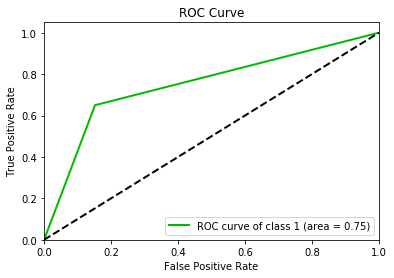

In [12]:
decision_tree = DecisionTreeClassifier()
get_classification_results(decision_tree, 'Decision Tree', x, x_ans, y_values)

Pruned Decision Tree
                          Schizophrenic Non-Schizophrenic 
        Schizophrenic              38.0               8.0 
    Non-Schizophrenic              15.0              25.0 

 Accuracy: 0.7325581395348837


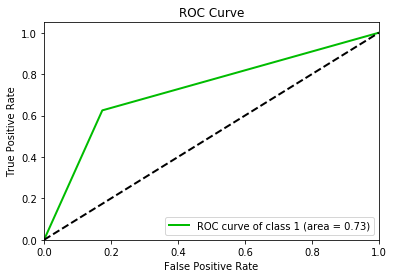

In [13]:
# Pruning (stop tree generation early)
pruned_decision_tree = DecisionTreeClassifier(max_depth = 3, max_leaf_nodes = 10, min_samples_leaf = 5)
get_classification_results(pruned_decision_tree, 'Pruned Decision Tree', x, x_ans, y_values)

#### Visualization

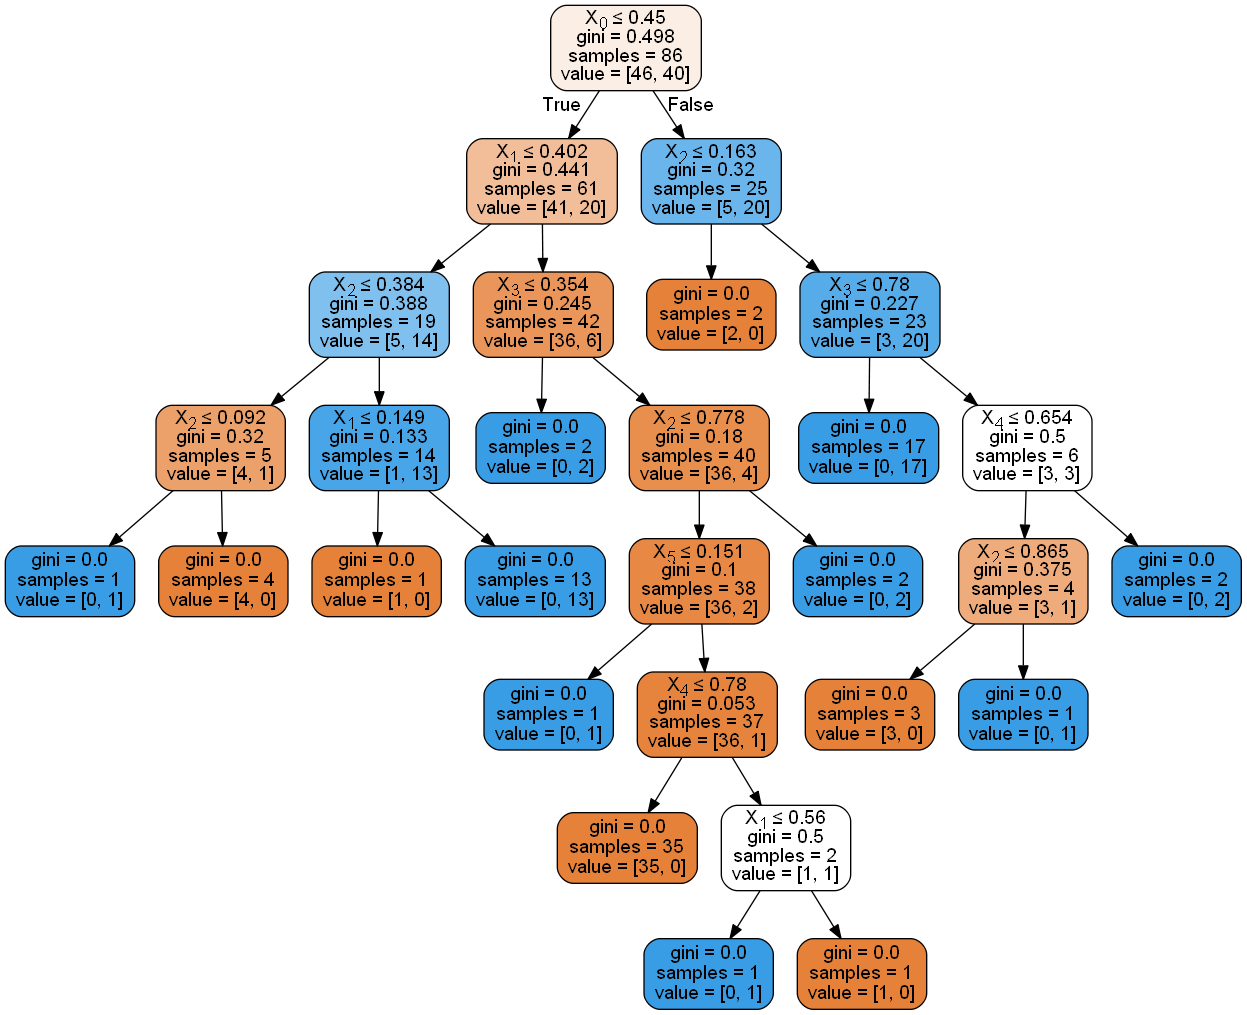

In [14]:
# Decision Tree
dot_data = StringIO()
sk.tree.export_graphviz(decision_tree, out_file = dot_data, filled = True, 
                        rounded = True, special_characters = True)
graph = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

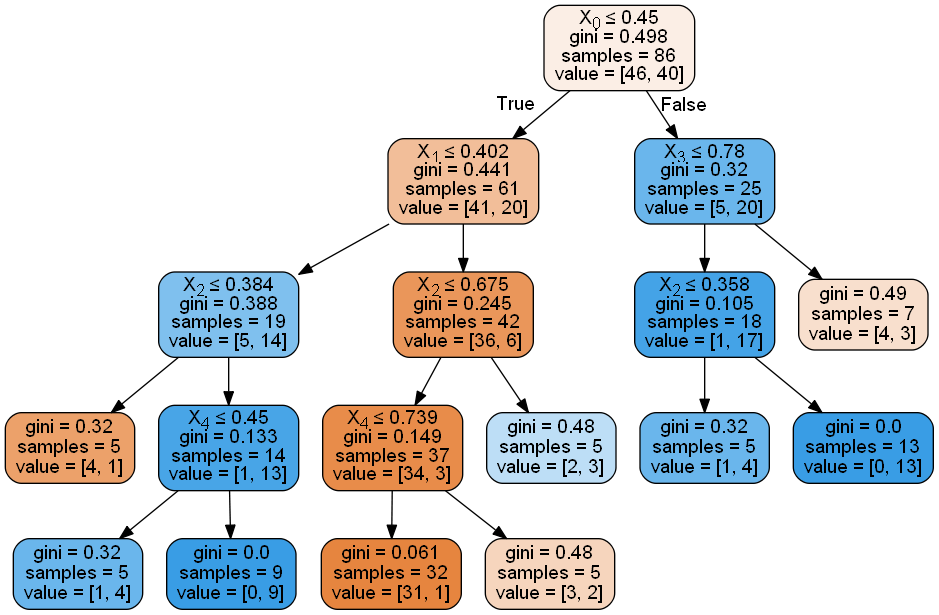

In [15]:
# Pruned Decision Tree
pruned_dot_data = StringIO()
sk.tree.export_graphviz(pruned_decision_tree, out_file = pruned_dot_data, filled = True, 
                        rounded = True, special_characters = True)
pruned_graph = graph_from_dot_data(pruned_dot_data.getvalue())
Image(pruned_graph.create_png())

### K-NN

KNN
                          Schizophrenic Non-Schizophrenic 
        Schizophrenic              40.0               6.0 
    Non-Schizophrenic              13.0              27.0 

 Accuracy: 0.7790697674418605


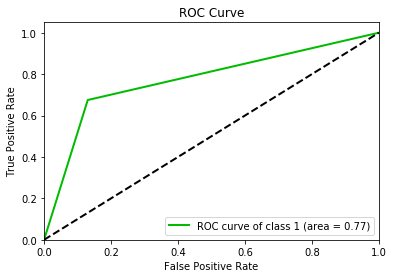

In [16]:
KNN = KNeighborsClassifier(n_neighbors = 5)
get_classification_results(KNN, 'KNN', x, x_ans, y_values)

KNN Grid
                          Schizophrenic Non-Schizophrenic 
        Schizophrenic              38.0               8.0 
    Non-Schizophrenic              13.0              27.0 

 Accuracy: 0.7558139534883721


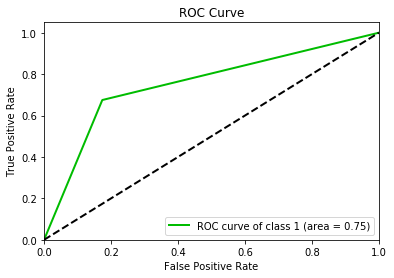

{'n_neighbors': 13}


In [17]:
# Grid Search
training_sample_size_5_fold = len(x) // 5 * 4
param_grid = {'n_neighbors': list(range(1, training_sample_size_5_fold))}
grid_KNN = GridSearchCV(KNeighborsClassifier(n_neighbors = 5), param_grid, cv = 5, scoring = 'accuracy')
get_classification_results(grid_KNN, 'KNN Grid', x, x_ans, y_values)
print(grid_KNN.best_params_)

### Logistic Regression

Logistic Regression
                          Schizophrenic Non-Schizophrenic 
        Schizophrenic              41.0               5.0 
    Non-Schizophrenic               9.0              31.0 

 Accuracy: 0.8372093023255814


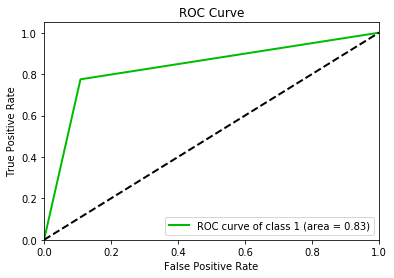

In [18]:
logistic_regression = LogisticRegression()
get_classification_results(logistic_regression, 'Logistic Regression', x, x_ans, y_values)

### No Normalization With Feature Selection

In [19]:
# Descriptive Summary (for selected model before normalization)
no_norm_x = raw_train_data[['SBM_map67', 'FNC220', 'SBM_map17', 'FNC189', 'FNC279', 'FNC313']]
print(no_norm_x.describe())
no_norm_x_ans = raw_test_data[['SBM_map67', 'FNC220', 'SBM_map17', 'FNC189', 'FNC279', 'FNC313']]

       SBM_map67     FNC220  SBM_map17     FNC189     FNC279     FNC313
count  86.000000  86.000000  86.000000  86.000000  86.000000  86.000000
mean    0.057342   0.209881   0.038051   0.493786   0.106063   0.401780
std     0.913446   0.262137   1.095996   0.203900   0.285707   0.239752
min    -2.207213  -0.385890  -2.266664  -0.169750  -0.636780  -0.280370
25%    -0.558446   0.019950  -0.839474   0.379558  -0.043583   0.281633
50%    -0.106795   0.194355   0.069828   0.519925   0.112425   0.409040
75%     0.722758   0.404083   0.768192   0.639895   0.301588   0.579923
max     3.662300   0.732770   2.959008   0.892000   0.846940   0.834670


#### Logistic Regression

No Normalization Logistic Regression
                          Schizophrenic Non-Schizophrenic 
        Schizophrenic              41.0               5.0 
    Non-Schizophrenic               9.0              31.0 

 Accuracy: 0.8372093023255814


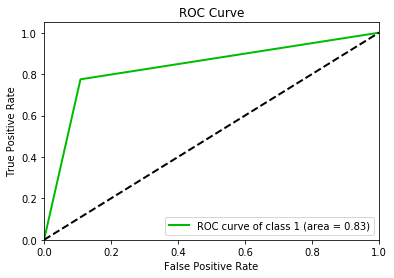

In [20]:
get_classification_results(logistic_regression, 'No Normalization Logistic Regression', no_norm_x, no_norm_x_ans, y_values)

### Normalization With No Feature Selection

In [21]:
no_feature_selection_x = train_data.iloc[:,1:]
no_feature_selection_x_ans = test_data.iloc[:,1:]

#### Logistic Regression

No Feature Selection Logistic Regression
                          Schizophrenic Non-Schizophrenic 
        Schizophrenic              34.0              12.0 
    Non-Schizophrenic              13.0              27.0 

 Accuracy: 0.7093023255813954


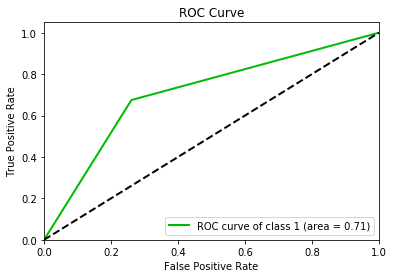

In [22]:
get_classification_results(logistic_regression, 'No Feature Selection Logistic Regression', 
                           no_feature_selection_x, no_feature_selection_x_ans, y_values)

### No Normalization or Feature Selection

In [23]:
raw_x = raw_train_data.iloc[:,1:]
raw_x_ans = raw_test_data.iloc[:,1:]

#### Logistic Regression

No Normalization or Feature Selection Logistic Regression
                          Schizophrenic Non-Schizophrenic 
        Schizophrenic              35.0              11.0 
    Non-Schizophrenic              14.0              26.0 

 Accuracy: 0.7093023255813954


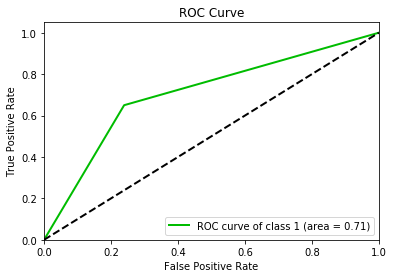

In [24]:
get_classification_results(logistic_regression, 'No Normalization or Feature Selection Logistic Regression', 
                           raw_x, raw_x_ans, y_values)

#### Bagging

Bagging
                          Schizophrenic Non-Schizophrenic 
        Schizophrenic              36.0              10.0 
    Non-Schizophrenic              21.0              19.0 

 Accuracy: 0.6395348837209303


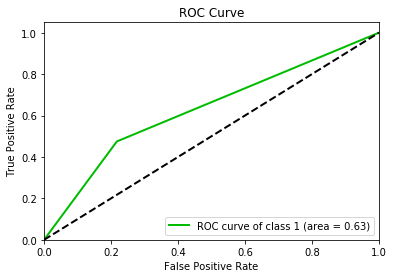

In [25]:
bagging = BaggingClassifier()
get_classification_results(bagging, 'Bagging', raw_x, raw_x_ans, y_values)

#### Random Forest

Random Forest
                          Schizophrenic Non-Schizophrenic 
        Schizophrenic              37.0               9.0 
    Non-Schizophrenic              25.0              15.0 

 Accuracy: 0.6046511627906976


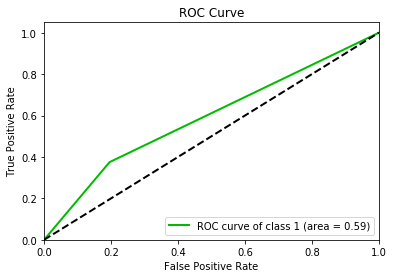

In [26]:
random_forest = RandomForestClassifier()
get_classification_results(random_forest, 'Random Forest', raw_x, raw_x_ans, y_values)

#### Boosting

Gradient Boosting
                          Schizophrenic Non-Schizophrenic 
        Schizophrenic              25.0              21.0 
    Non-Schizophrenic              19.0              21.0 

 Accuracy: 0.5348837209302325


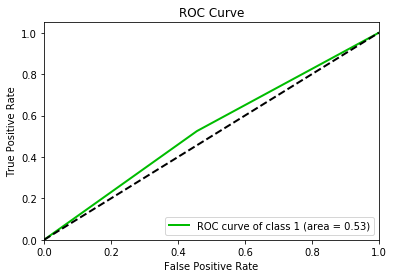

In [27]:
gradient_boosting = GradientBoostingClassifier()
get_classification_results(gradient_boosting, 'Gradient Boosting', raw_x, raw_x_ans, y_values)

#### XGBoost

XGBoost
                          Schizophrenic Non-Schizophrenic 
        Schizophrenic              22.0              24.0 
    Non-Schizophrenic              25.0              15.0 

 Accuracy: 0.43023255813953487


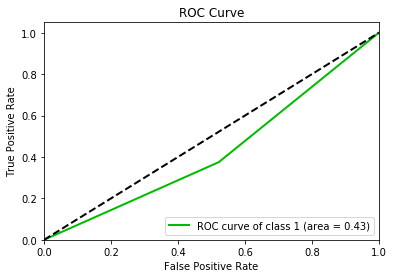

In [28]:
param_dist = {'objective': 'binary:logistic', 'n_estimators': 5}
XGBoost = XGBClassifier(**param_dist)
get_classification_results(XGBoost, 'XGBoost', raw_x, raw_x_ans, y_values)

#### SVM

Linear Kernel SVM
                          Schizophrenic Non-Schizophrenic 
        Schizophrenic              32.0              14.0 
    Non-Schizophrenic              12.0              28.0 

 Accuracy: 0.6976744186046512


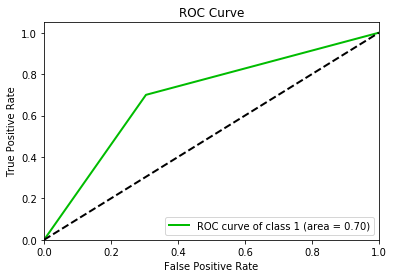

In [29]:
# Linear Kernel
linear_kernel_SVM = sk.svm.SVC(kernel = "linear", probability = True)
get_classification_results(linear_kernel_SVM, 'Linear Kernel SVM', raw_x, raw_x_ans, y_values)

Sigmoid Kernel SVM
                          Schizophrenic Non-Schizophrenic 
        Schizophrenic              44.0               2.0 
    Non-Schizophrenic              34.0               6.0 

 Accuracy: 0.5813953488372093


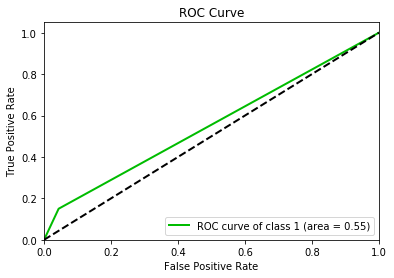

In [30]:
# Sigmoid Kernel
sigmoid_kernel_SVM = sk.svm.SVC(kernel = "sigmoid", probability = True)
get_classification_results(sigmoid_kernel_SVM, 'Sigmoid Kernel SVM', raw_x, raw_x_ans, y_values)

Radial Kernel SVM
                          Schizophrenic Non-Schizophrenic 
        Schizophrenic              41.0               5.0 
    Non-Schizophrenic              24.0              16.0 

 Accuracy: 0.6627906976744186


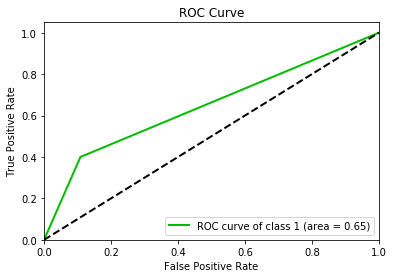

In [31]:
# Radial Kernel
radial_kernel_SVM = sk.svm.SVC(kernel = "rbf", probability = True)
get_classification_results(radial_kernel_SVM, 'Radial Kernel SVM', raw_x, raw_x_ans, y_values)

#### Neural Network

Neural Network
                          Schizophrenic Non-Schizophrenic 
        Schizophrenic              36.0              10.0 
    Non-Schizophrenic              13.0              27.0 

 Accuracy: 0.7325581395348837


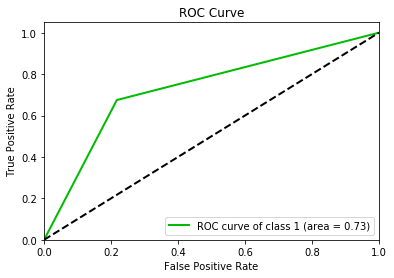

In [32]:
neural_network = MLPClassifier(solver = 'lbfgs')
get_classification_results(neural_network, 'Neural Network', raw_x, raw_x_ans, y_values)

#### Ensemble Learning

Ensemble Learning
                          Schizophrenic Non-Schizophrenic 
        Schizophrenic              36.0              10.0 
    Non-Schizophrenic              13.0              27.0 

 Accuracy: 0.7325581395348837


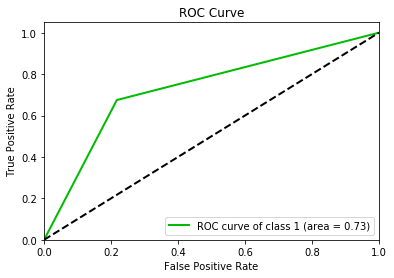

In [33]:
ensemble = [('Radial Kernel SVM', radial_kernel_SVM), ('Neural Network', neural_network), 
            ('Logistic Regression', logistic_regression)]
ensemble_learning = VotingClassifier(estimators = ensemble, voting = 'soft')
get_classification_results(ensemble_learning, 'Ensemble Learning', raw_x, raw_x_ans, y_values)